Saved architecture diagram to: fraud_nn_architecture.png


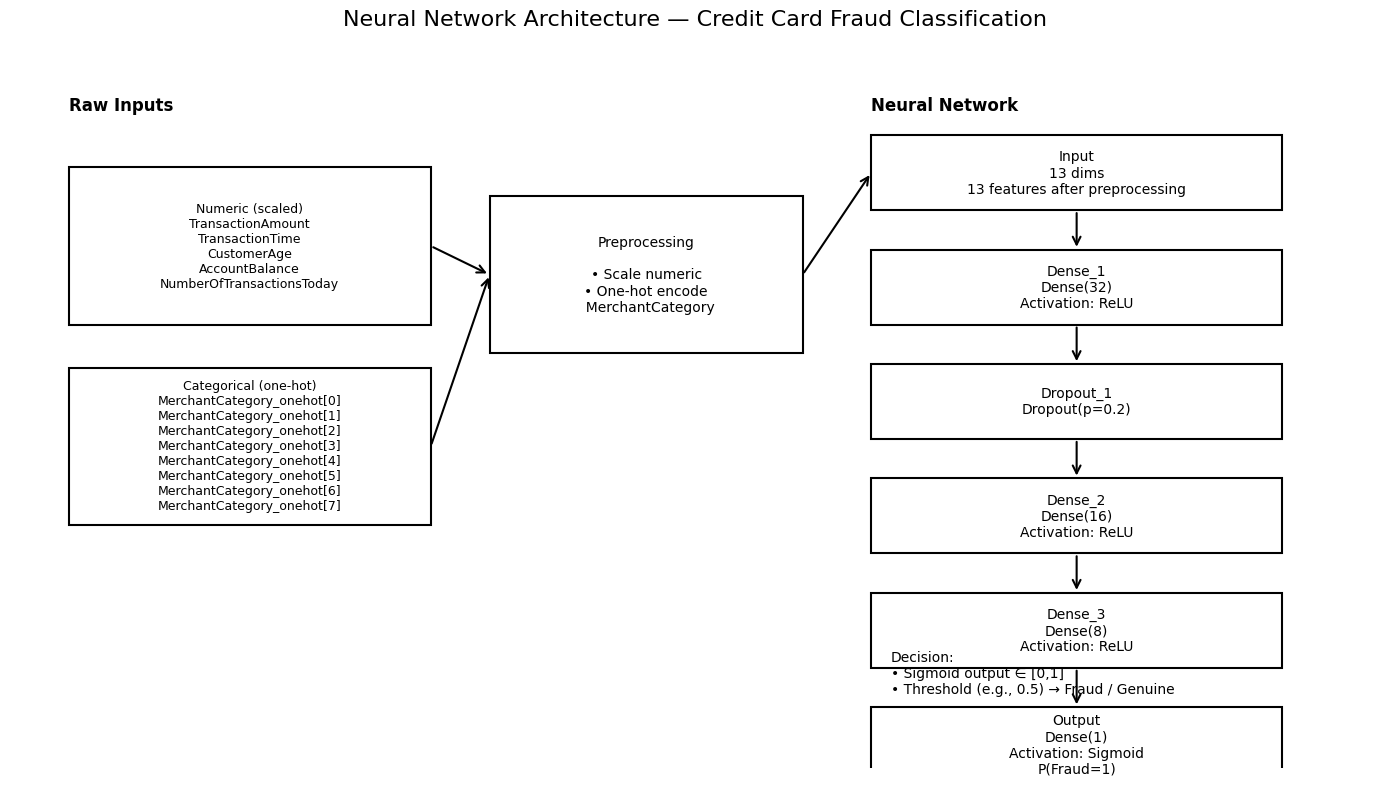

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
"""
Neural Network Architecture Visualization for Credit Card Fraud Detection

Features:
- TransactionAmount (numeric)
- TransactionTime (numeric or engineered time features)
- MerchantCategory (categorical)
- CustomerAge (numeric)
- AccountBalance (numeric)
- NumberOfTransactionsToday (numeric)
Label:
- Fraud (0 = Genuine, 1 = Fraud)

This script:
1) Defines a Keras model for binary classification.
2) Visualizes the architecture as a diagram (Matplotlib) without requiring Graphviz.
"""

from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch


# ----------------------------
# Model "spec" (for drawing)
# ----------------------------

@dataclass
class LayerSpec:
    name: str
    kind: str
    units: int | None = None
    activation: str | None = None
    details: str | None = None


def build_architecture_spec(
    merchant_category_onehot_dim: int = 8
) -> Tuple[Dict[str, List[str]], List[LayerSpec]]:
    """
    Creates:
    - input feature groups (numeric + categorical expanded)
    - a simple feed-forward NN architecture spec
    """

    numeric_features = [
        "TransactionAmount",
        "TransactionTime",
        "CustomerAge",
        "AccountBalance",
        "NumberOfTransactionsToday",
    ]

    categorical_features = ["MerchantCategory"]
    categorical_expanded = [f"MerchantCategory_onehot[{i}]" for i in range(merchant_category_onehot_dim)]

    inputs = {
        "Numeric (scaled)": numeric_features,
        "Categorical (one-hot)": categorical_expanded,
    }

    # Total input dims after preprocessing
    input_dim = len(numeric_features) + merchant_category_onehot_dim

    layers = [
        LayerSpec(name=f"Input", kind="input", units=input_dim, details=f"{input_dim} features after preprocessing"),
        LayerSpec(name="Dense_1", kind="dense", units=32, activation="ReLU"),
        LayerSpec(name="Dropout_1", kind="dropout", details="Dropout(p=0.2)"),
        LayerSpec(name="Dense_2", kind="dense", units=16, activation="ReLU"),
        LayerSpec(name="Dense_3", kind="dense", units=8, activation="ReLU"),
        LayerSpec(name="Output", kind="output", units=1, activation="Sigmoid", details="P(Fraud=1)"),
    ]

    return inputs, layers


# ----------------------------
# Draw architecture (Matplotlib)
# ----------------------------

def draw_nn_architecture(
    inputs: Dict[str, List[str]],
    layers: List[LayerSpec],
    title: str = "Neural Network Architecture — Credit Card Fraud Classification",
    save_path: str | None = "fraud_nn_architecture.png"
) -> None:
    """
    Draws a clean architecture diagram using Matplotlib.

    - Left side: feature preprocessing (scaling + one-hot)
    - Center/right: neural network layers
    """

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis("off")
    ax.set_title(title, fontsize=16, pad=20)

    # Helper to draw labeled boxes
    def box(x, y, w, h, text, fontsize=10):
        rect = Rectangle((x, y), w, h, fill=False, linewidth=1.5)
        ax.add_patch(rect)
        ax.text(x + w / 2, y + h / 2, text, ha="center", va="center", fontsize=fontsize, wrap=True)
        return rect

    # Helper to draw arrows
    def arrow(x1, y1, x2, y2):
        a = FancyArrowPatch((x1, y1), (x2, y2), arrowstyle="->", mutation_scale=14, linewidth=1.5)
        ax.add_patch(a)

    # ---- Left: Inputs & preprocessing ----
    left_x = 0.6
    top_y = 8.6

    ax.text(left_x, top_y + 0.6, "Raw Inputs", fontsize=12, fontweight="bold")

    y_cursor = top_y
    input_boxes = []
    for group_name, feats in inputs.items():
        group_text = group_name + "\n" + "\n".join(feats[:8]) + (("\n...") if len(feats) > 8 else "")
        r = box(left_x, y_cursor - 2.4, 3.7, 2.2, group_text, fontsize=9)
        input_boxes.append(r)
        y_cursor -= 2.8

    # Preprocessing box
    prep = box(4.9, 5.8, 3.2, 2.2, "Preprocessing\n\n• Scale numeric\n• One-hot encode\n  MerchantCategory", fontsize=10)

    # Arrows from inputs to preprocessing
    for r in input_boxes:
        arrow(r.get_x() + r.get_width(), r.get_y() + r.get_height() / 2, prep.get_x(), prep.get_y() + prep.get_height() / 2)

    # ---- Right: Network layers ----
    net_x_start = 8.8
    net_y = 7.8
    layer_w = 4.2
    layer_h = 1.05
    gap_y = 0.55

    ax.text(net_x_start, 9.2, "Neural Network", fontsize=12, fontweight="bold")

    layer_rects = []
    y = net_y
    for layer in layers:
        if layer.kind == "input":
            label = f"{layer.name}\n{layer.units} dims\n{layer.details}"
        elif layer.kind == "dense":
            label = f"{layer.name}\nDense({layer.units})\nActivation: {layer.activation}"
        elif layer.kind == "dropout":
            label = f"{layer.name}\n{layer.details}"
        elif layer.kind == "output":
            label = f"{layer.name}\nDense({layer.units})\nActivation: {layer.activation}\n{layer.details}"
        else:
            label = layer.name

        rect = box(net_x_start, y, layer_w, layer_h, label, fontsize=10)
        layer_rects.append(rect)
        y -= (layer_h + gap_y)

    # Arrow from preprocessing to first layer
    arrow(prep.get_x() + prep.get_width(), prep.get_y() + prep.get_height() / 2,
          layer_rects[0].get_x(), layer_rects[0].get_y() + layer_h / 2)

    # Arrows between layers
    for i in range(len(layer_rects) - 1):
        r1, r2 = layer_rects[i], layer_rects[i + 1]
        arrow(r1.get_x() + r1.get_width() / 2, r1.get_y(),
              r2.get_x() + r2.get_width() / 2, r2.get_y() + layer_h)

    # Output interpretation text
    ax.text(9.0, 1.0, "Decision:\n• Sigmoid output ∈ [0,1]\n• Threshold (e.g., 0.5) → Fraud / Genuine",
            fontsize=10, ha="left", va="bottom")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"Saved architecture diagram to: {save_path}")

    plt.show()


# ----------------------------
# (Optional) Define actual Keras model (not required for drawing)
# ----------------------------

def build_keras_model(input_dim: int):
    """
    Optional: builds the actual NN in TensorFlow/Keras.

    Install: pip install tensorflow
    """
    import tensorflow as tf
    from tensorflow.keras import layers, models

    model = models.Sequential([
        layers.Input(shape=(input_dim,), name="Input"),
        layers.Dense(32, activation="relu", name="Dense_1"),
        layers.Dropout(0.2, name="Dropout_1"),
        layers.Dense(16, activation="relu", name="Dense_2"),
        layers.Dense(8, activation="relu", name="Dense_3"),
        layers.Dense(1, activation="sigmoid", name="Output"),
    ])

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model


# ----------------------------
# Main
# ----------------------------

if __name__ == "__main__":
    # Assume MerchantCategory has 8 possible categories after one-hot encoding
    # (Change this to match your dataset)
    inputs, layers = build_architecture_spec(merchant_category_onehot_dim=8)

    # Draw the architecture
    draw_nn_architecture(inputs, layers, save_path="fraud_nn_architecture.png")

    # Optional: create the actual Keras model too
    input_dim = layers[0].units  # from spec
    try:
        model = build_keras_model(input_dim)
        model.summary()
    except Exception as e:
        print("\nKeras model build skipped (TensorFlow not installed or error).")
        print("Reason:", e)
